# Figure 3: Proteasome expression increases approaching senescence may explain preserved ub-independent substrate degradation

## Import libraries

In [1]:
from importlib import reload

import os
import re

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import skimage as sk
import os
import re
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns
from statannotations.Annotator import Annotator

from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter

wbf = WeibullFitter()
kmf = KaplanMeierFitter()

from byc import constants, files, database, segmentation
from byc import standard_analysis as sa
from byc import plotting
from byc import fitting_tools as ft

from byc import constants, plotting, files, database, utilities, trace_tools, fitting_tools, segmentation
from byc import standard_analysis as sa
from byc.trace_tools import median_filter
median_filter
from importlib import reload
for pac in [constants,
            plotting,
            files,
            sa,
            database,
            utilities,
            trace_tools,
            fitting_tools,
            segmentation]:
    reload(pac)
    
plotting.set_styles(plt, matplotlib)

strains_color_dict =  plotting.strains_color_dict
other_colors = plotting.other_colors

# Generate a palette to use for signifying number of 
# buds that will be produced before the last bud
pre_post_SEP_palette = plotting.get_pre_post_sep_palette()

## Generate fits, trace, and buds dataframes *de novo*

Do this after analyzing new experiments in `constants.byc_data_dir` and adding them to the compartments_index.csv at `constants.compartment_index_path`

In [2]:
scriptpath = os.path.join(constants.source_path, 'bin/refresh_database.py')
%run $scriptpath

Found date 20190726, compartment name 20190726_byc_pJC010_pdr5d_DsRed-P2A-UBL-YFP-NS
Found date 20190920, compartment name 20190920_byc_pJC010
Found date 20190920, compartment name 20190920_byc_pJC010_in_pdr5d_DsRed-P2A-UBL-YFP-Su9_CEN4
Found date 20190927, compartment name rpn4delta_pJC010_old_(002_003)
Found date 20190927, compartment name rpn4delta_pJC010_young_(001)
Found date 20191008, compartment name pdr5d_pJC010_young_chase
Found date 20210323, compartment name 20210323_byc_pJC272_BY4741_young_chase
Found date 20210323, compartment name 20210323_byc_pJC272_rpn4d_young_chase
Found date 20210401, compartment name 20210401_byc_pJC272_BY4741_old_chase
Found date 20210430, compartment name 20210430_(RKK-sYFP2-Su9)x2_JPC063_young_old_chase
Found date 20210507, compartment name 20210507_sYFP2-ODC_old_chase
Found date 20210514, compartment name 20210514_JPC063_RKK-sYFP2-Su9_old_chase
Found date 20210527, compartment name 20210527_sYFP2-ODC(47)x3_JPC082_pJC380_old_chase
Found date 20210

C:\Users\johnp\Dropbox\Projects\byc\byc\database.py:312: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:, column] = np.nan
C:\Users\johnp\Dropbox\Projects\byc\byc\database.py:312: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:, column] = np.nan
C:\Users\johnp\Dropbox\Projects\byc\byc\database.py:312: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

Adding columns mating_type
Adding columns can1delta
Adding columns substrate
Adding columns other_genetic_feature
Adding columns plasmid
Adding columns background_strain
Adding columns strain_name
Adding columns xform_date
Adding columns rls_suitable
Adding columns tet_stock_concn
Adding columns pre-load-spin
Adding columns pre-load-vortex
Adding columns potential_blue_light_exposure_during_filter_cube_switching
Adding columns GFP_imaged
Labeling data from compartment 20210430_(RKK-sYFP2-Su9)x2_JPC063_young_old_chase
Adding columns background_genotype
Adding columns mating_type
Adding columns can1delta
Adding columns substrate
Adding columns other_genetic_feature
Adding columns plasmid
Adding columns background_strain
Adding columns strain_name
Adding columns xform_date
Adding columns rls_suitable
Adding columns tet_stock_concn
Adding columns pre-load-spin
Adding columns pre-load-vortex
Adding columns potential_blue_light_exposure_during_filter_cube_switching
Adding columns GFP_imaged


C:\Users\johnp\Dropbox\Projects\byc\bin\refresh_database.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  traces_df.loc[:, 'dist_from_sen_bin'] = np.nan
C:\Users\johnp\Dropbox\Projects\byc\bin\refresh_database.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:, 'measdex'] = measdex


Saved dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data/meta/traces_df.csv.gzip
Saved dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data/meta/fits_df.csv.gzip
Saved dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data/meta/buds_df.csv.gzip
Saved dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data/meta/traces_df.csv
Saved dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data/meta/fits_df.csv
Saved dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data/meta/buds_df.csv


## Read in databases

In [2]:
traces_df, fits_df, buds_df = database.read_in_trace_fits_buds_dfs()

C:\Users\johnp\Dropbox\Projects\byc\byc\database.py:646: DtypeWarning: Columns (64,66,71,85,89,90,94,96,97,98,99,100,101,102,103,104,105,106,107,108,172,173,175,177,209,213,214,216,217,218,219) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(savepath, compression='gzip')


Read dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data/meta/traces_df.csv.gzip


C:\Users\johnp\Dropbox\Projects\byc\byc\database.py:646: DtypeWarning: Columns (64,66,83,87,88,141,142,144,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(savepath, compression='gzip')


Read dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data/meta/fits_df.csv.gzip
Read dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data/meta/buds_df.csv.gzip


C:\Users\johnp\Dropbox\Projects\byc\byc\database.py:646: DtypeWarning: Columns (41,50,51,53,54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(savepath, compression='gzip')


## Read in the continuous signal data

In [3]:
compartments = [
    '20230201_byc_JPC245_Pre6-GFP_BY4741',
    '20230224_byc_JPC246_Rpt1-GFP_BY4741',
    '20230112_byc_JPC190_PSR',
    '20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry_full-traces'
]

channels = [
    'gfp',
    'gfp',
    'gfp',
    'rfp'
]

sensors = [
    'Pre6-GFP',
    'Rpt1-GFP',
    'Rpn4-driven GFP',
    'HSP104-mCherry'
]
dfs = []
for idx, compname in enumerate(compartments):
    exptname = utilities.exptname_from_compartment(compname)
    compdir = files.get_byc_compartmentdir(exptname, compname)
    tracesdfpath = os.path.join(compdir, f'{exptname}_alldf.csv')
    df = pd.read_csv(tracesdfpath)
    df.loc[:, 'compartment_name'] = compname
    df.loc[:, 'sensor'] = sensors[idx]
    if 'level_0' in df.columns:
        del df['level_0']
    # Create a column with generic fluorescence name
    # so values can be plotted on same axis
    for col in df.columns:
        channel = channels[idx]
        query = f'{channel}_mean'
        if query in col:
            df.loc[:, col.replace(query, 'fluor_mean')] = df.loc[:, col]
    # Calculate a background fluorescence value
    # That will be used for final normalization
    bg_fluor = df.fluor_mean.min()
    df.loc[:, 'fluor_mean_norm_to_pre_sep'] = np.nan
    for cell_index in df.cell_index.unique():
        cellbool = df.cell_index == cell_index
        youngbool = df.dist_from_sen > 5
        val_to_norm = df.loc[cellbool & youngbool, 'fluor_mean'].mean() - bg_fluor
        df.loc[cellbool, 'fluor_mean_norm_to_pre_sep'] = (df.fluor_mean - bg_fluor)/val_to_norm
    dfs.append(df)

tracesdf = pd.concat(dfs).reset_index()
if 'level_0' in tracesdf.columns:
    del tracesdf['level_0']
tracesdf.index = range(len(tracesdf))
tracesdf.loc[:, 'hours_before_last_bud'] = 0 - tracesdf.hours_after_last_bud

C:\Users\johnp\AppData\Local\Temp\ipykernel_28116\3263348962.py:26: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(tracesdfpath)


## Raw fluorescence for each sensor in the dataset

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\notebooks\plots\20230201_byc_JPC245_Pre6-GFP_BY4741-20230224_byc_JPC246_Rpt1-GFP_BY4741-20230112_byc_JPC190_PSR-20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry_full-traces_x=hours_before_last_bud_y=fluor_mean_hue=compartment_name.png


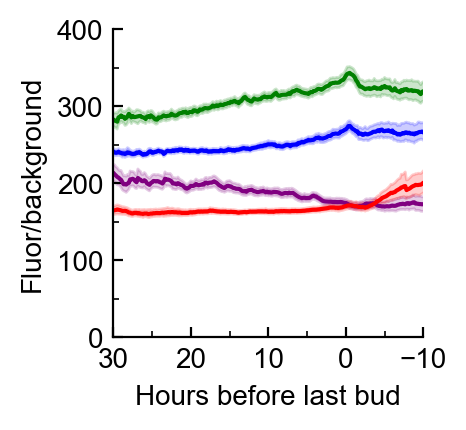

In [8]:
from byc import plotting, constants

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
plotting.set_styles(matplotlib, plt)

filetype = 'png'
xlim = (30, -10)
majorxtickspace = 10
ylim = (0, 400)

fig, ax = plotting.figure_ax()
fig.set_dpi(200)

kwargs = {
    'x': 'hours_before_last_bud',
    'y': 'fluor_mean',
    'hue': 'compartment_name',
    'data': tracesdf,
    'palette': ['blue', 'green', 'purple', 'red'],
    'estimator': np.mean,
    'hue_order': compartments
}

sns.lineplot(**kwargs)
ax.set_xlim(xlim)
ax.set_xticks(np.arange(np.min(xlim), np.max(xlim) + 0.01*np.max(xlim), majorxtickspace))
ax.set_ylim(ylim)

ax.set_xlabel('Hours before last bud')
ax.set_ylabel('Fluor/background')
plotting.format_ticks(ax)
ax.legend_.set_visible(False)

filename = '_'.join([f'{key}={val}' for key, val in kwargs.items() if key not in ['data', 'estimator', 'hue_order', 'palette']])
compnames = '-'.join(compartments)
filename = f'{compnames}_{filename}.{filetype}'
savepath = os.path.abspath(os.path.join(constants.source_path, f'notebooks/plots/{filename}'))
fig.savefig(savepath)
print(f'Saved figure at\n{savepath}')

## Normalized signal of each sensor vs. hours before before last bud

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\notebooks\plots\20230201_byc_JPC245_Pre6-GFP_BY4741-20230224_byc_JPC246_Rpt1-GFP_BY4741-20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry_full-traces_x=hours_after_last_bud_y=fluor_mean_norm_to_pre_sep_hue=compartment_name.svg


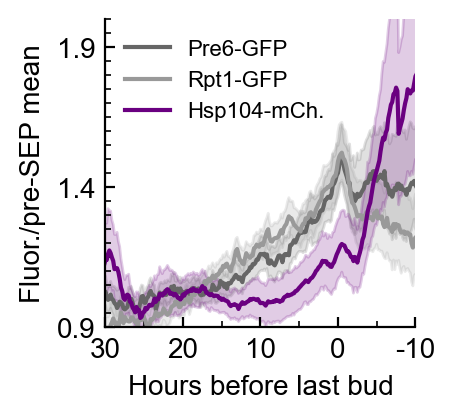

In [5]:
from byc import plotting, constants

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
plotting.set_styles(matplotlib, plt)

compartments = [
    '20230201_byc_JPC245_Pre6-GFP_BY4741',
    '20230224_byc_JPC246_Rpt1-GFP_BY4741',
    '20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry_full-traces'
]

filetype = 'svg'
xlim = (-30, 10)
majorxtickspace = 10
ylim = (0.9, 2)

fig, ax = plotting.figure_ax()
fig.set_dpi(200)

kwargs = {
    'x': 'hours_after_last_bud',
    'y': 'fluor_mean_norm_to_pre_sep',
    'hue': 'compartment_name',
    'data': tracesdf[tracesdf.compartment_name.isin(compartments)],
    'palette': [other_colors['Pre6'], (153/255, 153/255, 153/255), other_colors['Hsp104']],
    'estimator': np.mean,
    'hue_order': compartments
}

sns.lineplot(**kwargs)
ax.set_xlim(xlim)
ax.set_xticks(np.arange(np.min(xlim), np.max(xlim) + 0.01*np.max(xlim), majorxtickspace))
xlabels = [int(val) for val in np.arange(-10, 31, 10)]
xlabels.reverse()
ax.set_xticklabels(xlabels)
ax.set_ylim(ylim)
ax.set_yticks(np.arange(np.min(ylim), np.max(ylim)+0.01, 0.5))

ax.set_xlabel('Hours before last bud')
ax.set_ylabel('Fluor./pre-SEP mean')
plotting.format_ticks(ax, xminorspace=5, yminorspace=0.05)

# Create new legend
labels = [
    'Pre6-GFP',
    'Rpt1-GFP',
    'Hsp104-mCh.'
]
ax.legend(
    ax.get_legend_handles_labels()[0],
    labels,
    title='',
    frameon=False,
    fontsize=8
)

filename = '_'.join([f'{key}={val}' for key, val in kwargs.items() if key not in ['data', 'estimator', 'hue_order', 'palette']])
compnames = '-'.join(compartments)
filename = f'{compnames}_{filename}.{filetype}'
savepath = os.path.abspath(os.path.join(constants.source_path, f'notebooks/plots/{filename}'))
fig.savefig(savepath)
print(f'Saved figure at\n{savepath}')

## Normalized signal of each sensor vs. buds before death

C:\Users\johnp\AppData\Local\Temp\ipykernel_28116\1630413263.py:49: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(**kwargs)


Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\notebooks\plots\20230201_byc_JPC245_Pre6-GFP_BY4741-20230224_byc_JPC246_Rpt1-GFP_BY4741_x=dist_from_sen_y=fluor_mean_norm_to_pre_sep_hue=compartment_name_errorbar=('ci', 95).svg


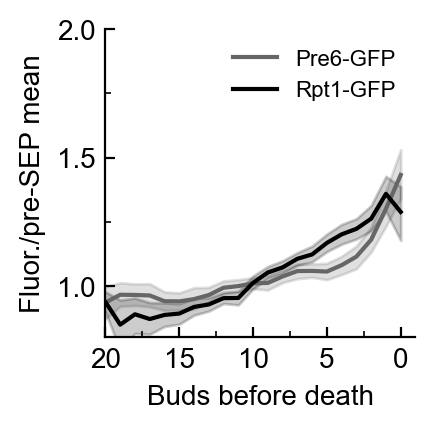

In [6]:
from byc import plotting, constants

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
plotting.set_styles(matplotlib, plt)

compartments = [
    '20230201_byc_JPC245_Pre6-GFP_BY4741',
    '20230224_byc_JPC246_Rpt1-GFP_BY4741',
    '20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry_full-traces'
]

compartments = [
    '20230201_byc_JPC245_Pre6-GFP_BY4741',
    '20230224_byc_JPC246_Rpt1-GFP_BY4741',
]

subdf = tracesdf[tracesdf.compartment_name.isin(compartments)]
idx = [
    'compartment_name',
    'cell_index',
    'dist_from_sen'
]

cols = idx + ['fluor_mean_norm_to_pre_sep']

subdf = subdf.loc[:, cols].pivot_table(index=idx, aggfunc=np.mean).reset_index()
filetype = 'svg'
xlim = (20, -1)
majorxtickspace = 5
ylim = (0.8, 2)

fig, ax = plotting.figure_ax()
fig.set_dpi(200)

kwargs = {
    'x': 'dist_from_sen',
    'y': 'fluor_mean_norm_to_pre_sep',
    'hue': 'compartment_name',
    'data': subdf,
    'palette': [other_colors['Pre6'], 'black', other_colors['Hsp104']],
    'estimator': np.mean,
    'hue_order': compartments,
    'errorbar':('ci', 95)
}

sns.lineplot(**kwargs)
ax.set_xlim(xlim)
ax.set_xticks(np.arange(0, 20 + 0.1, majorxtickspace))
ax.set_ylim(ylim)
ax.set_yticks(np.arange(1, np.max(ylim)+0.1, 0.5))

ax.set_xlabel('Buds before death')
ax.set_ylabel('Fluor./pre-SEP mean')
plotting.format_ticks(ax)

# Create new legend
labels = [
    'Pre6-GFP',
    'Rpt1-GFP',
    'Hsp104-mCh.'
]
ax.legend(
    ax.get_legend_handles_labels()[0],
    labels,
    title='',
    frameon=False,
    fontsize=8
)

filename = '_'.join([f'{key}={val}' for key, val in kwargs.items() if key not in ['data', 'estimator', 'hue_order', 'palette']])
compnames = '-'.join(compartments)
filename = f'{compnames}_{filename}.{filetype}'
savepath = os.path.abspath(os.path.join(constants.source_path, f'notebooks/plots/{filename}'))
fig.savefig(savepath)
print(f'Saved figure at\n{savepath}')

### Line plot of Hsp104-mCherry signal +/- aggregate vs. time

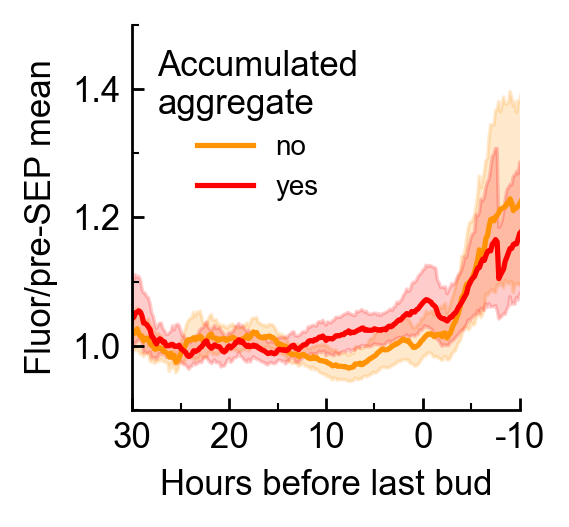

In [11]:
subtracedf = tracesdf[tracesdf.sensor=='HSP104-mCherry']
# Annotate aggregate presence on these fucking cells
for cell_index in subtracedf.cell_index.unique():
    path = subtracedf.loc[(subtracedf.cell_index==cell_index)&(~subtracedf.crop_rois_df_path.isna()), 'crop_rois_df_path'].iloc[0]
    crop_roi_df = pd.read_csv(path)
    contains_agg = crop_roi_df.loc[0, 'contains_aggregate']
    subtracedf.loc[subtracedf.cell_index==cell_index, 'contains_aggregate']= contains_agg
fig, ax = plotting.figure_ax()

kwargs = {
    'x': 'hours_after_last_bud',
    'y': 'fluor_mean_norm_to_pre_sep',
    'data': subtracedf,
    'ax': ax,
    'hue': 'contains_aggregate',
    'hue_order': ['no', 'yes'],
    'palette': [strains_color_dict['JPC121'], 'red']
}

sns.lineplot(**kwargs)
ax.set_ylabel('Fluor/pre-SEP mean')
ax.set_xlabel('Hours before last bud')
ax.set_xlim(-30, 10)
ax.set_xticks(np.arange(-30, 11, 10))
xticks = [int(val) for val in np.arange(-10, 31, 10)]
xticks.reverse()
ax.set_xticklabels(xticks)
ax.set_ylim(0.9, 1.5)

plotting.format_ticks(ax)
ax.legend(ax.get_legend_handles_labels()[0], ['no', 'yes'], title='Accumulated\naggregate', frameon=False, fontsize=8)

### Line plot of Hsp104-mCherry signal +/- aggregate vs. buds before death

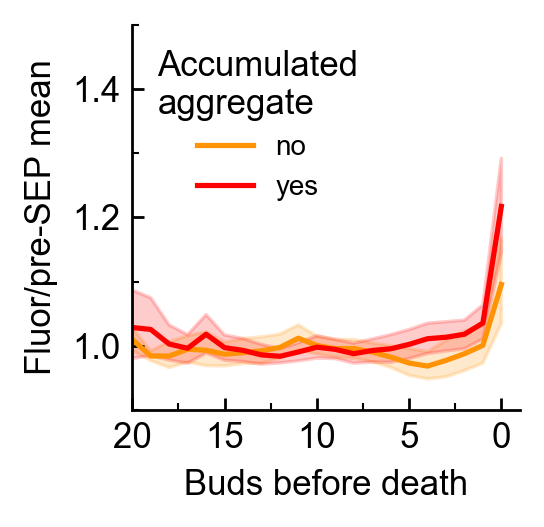

In [55]:
subtracedf = tracesdf[tracesdf.sensor=='HSP104-mCherry']
# Annotate aggregate presence on these fucking cells
for cell_index in subtracedf.cell_index.unique():
    path = subtracedf.loc[(subtracedf.cell_index==cell_index)&(~subtracedf.crop_rois_df_path.isna()), 'crop_rois_df_path'].iloc[0]
    crop_roi_df = pd.read_csv(path)
    contains_agg = crop_roi_df.loc[0, 'contains_aggregate']
    subtracedf.loc[subtracedf.cell_index==cell_index, 'contains_aggregate']= contains_agg
    
idx = [
    'sensor',
    'cell_index',
    'dist_from_sen',
    'contains_aggregate'
]

cols = idx + ['fluor_mean_norm_to_pre_sep']
subdf = subtracedf.loc[:, cols].pivot_table(index=idx, aggfunc=np.mean).reset_index()

fig, ax = plotting.figure_ax()

kwargs = {
    'x': 'dist_from_sen',
    'y': 'fluor_mean_norm_to_pre_sep',
    'data': subdf,
    'ax': ax,
    'hue': 'contains_aggregate',
    'hue_order': ['no', 'yes'],
    'palette': [strains_color_dict['JPC121'], 'red']
}

sns.lineplot(**kwargs)
ax.set_ylabel('Fluor/pre-SEP mean')
ax.set_xlabel('Buds before death')
ax.set_xlim(20, -1)
ax.set_xticks(np.arange(0, 21, 5))
ax.set_ylim(0.9, 1.5)

ax.legend(ax.get_legend_handles_labels()[0], ['no', 'yes'], title='Accumulated\naggregate', frameon=False, fontsize=8)
plotting.format_ticks(ax)

## Strip plots of signal before and after SEP

Rpt1-GFP_True vs. Rpt1-GFP_False: Mann-Whitney-Wilcoxon test two-sided, P_val:4.358e-63 U_stat=2.827e+05
Pre6-GFP_True vs. Pre6-GFP_False: Mann-Whitney-Wilcoxon test two-sided, P_val:6.463e-46 U_stat=1.529e+05
Hsp104-mCh._True vs. Hsp104-mCh._False: Mann-Whitney-Wilcoxon test two-sided, P_val:1.124e-03 U_stat=2.772e+05
Pre6-GFP fold change young over old=0.8158641842346901
Pre6-GFP fold change old over young=1.225694201710835
Rpt1-GFP fold change young over old=0.7877577329204892
Rpt1-GFP fold change old over young=1.2694258122895927
Hsp104-mCh. fold change young over old=0.8657202136363735
Hsp104-mCh. fold change old over young=1.1551076020272153
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=sensor_y=fluor_mean_norm_to_pre_sep_hue=post_sep_dodge=True.svg


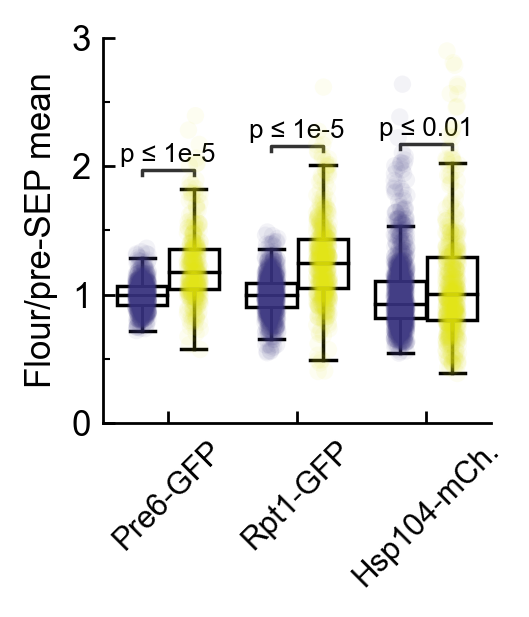

In [8]:
fig, ax = plotting.figure_ax(width_scale=1)

subdf = tracesdf[tracesdf.compartment_name.isin(compartments)]
sensors = [
    'Pre6-GFP',
    'Rpt1-GFP',
    'Hsp104-mCh.'
]
for i, sensor in enumerate(sensors):
    subdf.loc[subdf.compartment_name==compartments[i], 'sensor'] = sensor
# Aggregate data to one mean fluorescence per dist_from_sen per cell
idx = [
    'sensor',
    'compartment_name',
    'cell_index',
    'dist_from_sen'
]

cols = idx + ['fluor_mean_norm_to_pre_sep']

subdf = subdf.loc[:, cols].pivot_table(index=idx, aggfunc=np.mean).reset_index()
subdf.loc[subdf.dist_from_sen>5, 'post_sep'] = False
subdf.loc[subdf.dist_from_sen<5, 'post_sep'] = True

kwargs = {
    'x': 'sensor',
    'y': 'fluor_mean_norm_to_pre_sep',
    'hue': 'post_sep',
    'data': subdf,
    'ax': ax,
    'palette': plotting.get_pre_post_sep_palette(),
    'dodge': True,
    'order': sensors,
    'hue_order': [False, True]
}

sns.boxplot(**kwargs, **plotting.transparent_boxes_prop_dict, showfliers=False)
# annotate t-test results
data=kwargs['data']
x = kwargs['x']
y = kwargs['y']
hue = kwargs['hue']
order = kwargs['order']
box_pairs=[
    (('Pre6-GFP', True), ("Pre6-GFP", False)),
    (("Rpt1-GFP", True), ("Rpt1-GFP", False)),
    (("Hsp104-mCh.", True), ("Hsp104-mCh.", False))
]
test='Mann-Whitney'
text_format="simple"
loc="inside"

annotator = Annotator(ax, box_pairs, hue=hue, data=data, x=x, y=y, order=order,)
annotator.configure(test=test, text_format=text_format,
                    loc=loc, show_test_name=False,
                    line_width=1, fontsize=7.5)
annotator.apply_and_annotate()

sns.stripplot(**kwargs, alpha=0.06)
# ax.set_ylim(0.9, 1.3)
# ax.set_yticks(np.arange(0, ax.get_ylim()[1]+0.01, 2))
ax.set_ylabel('Flour/pre-SEP mean')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
ax.set_ylim(0, 3)
for sensor in sensors:
    slicedf = subdf[subdf.sensor==sensor]
    fold_change = slicedf.loc[subdf.post_sep==False, 'fluor_mean_norm_to_pre_sep'].mean()/slicedf.loc[subdf.post_sep==True, 'fluor_mean_norm_to_pre_sep'].mean()
    fold_change_old_over_young = 1/fold_change
    print(f'{sensor} fold change young over old={fold_change}')
    print(f'{sensor} fold change old over young={fold_change_old_over_young}')
ax.legend_.set_visible(False)
plotting.format_ticks(ax, add_minor_x=False)
plt.xticks(rotation = 45)
plotting.save_figure(fig, kwargs, ext='.svg')